# Scaling of online training workflow with libCEED

In [1]:
# Set up notebook
import os
import pathlib
import glob
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

from datetime import datetime

font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib.font_manager
# matplotlib.font_manager.fontManager.ttflist

## Full workflow performance on Polaris

In [4]:
class Workflow:
    def __init__(self,path,node_list,jobID):
        self.base_path = path
        self.node_list = node_list
        self.jobID = jobID
        self.n_nodes = len(node_list)
        self.sim_runtime = np.zeros((self.n_nodes,))
        self.sim_steps = np.zeros((self.n_nodes,))
        self.sim_sr_init = np.zeros((self.n_nodes,))
        self.sim_sr_meta = np.zeros((self.n_nodes,))
        self.sim_sr_train = np.zeros((self.n_nodes,))
        self.ml_runtime = np.zeros((self.n_nodes,))
        self.ml_sr_init = np.zeros((self.n_nodes,))
        self.ml_sr_meta = np.zeros((self.n_nodes,))
        self.ml_sr_train = np.zeros((self.n_nodes,))

    def get_sim_runtime(self,string):
        return float(string.split(":")[1].strip())
    
    def get_sim_steps(self,string):
        return float(string.split("step")[1].lstrip().split(' ')[0])
    
    def get_sim_sr_time(self,string,keyword):
        tmp = string.strip(keyword).lstrip()
        return list(map(float,tmp.split()))[2]
    
    def get_ml_time(self,string):
        tmp = string.split(":")[1].strip()
        tmp = tmp.split(",")[1]
        return float(tmp.split("=")[1].strip())

    def parse_files(self):
        counts = np.zeros((self.n_nodes,))
        for i in range(self.n_nodes):
            path = self.base_path+f"/{self.node_list[i]}/{self.jobID}*"
            # Loop over runs found
            run_files = glob.glob(path)
            for file in run_files:
                # Simulation performance
                fpath = file+"/sim.out"
                fh = open(fpath,'r')
                for l in fh:
                    if "Time taken for solution (sec):" in l:
                        self.sim_runtime[i] += self.get_sim_runtime(l)
                        counts[i] += 1
                    if "Time integrator CONVERGED_" in l:
                        self.sim_steps[i] += self.get_sim_steps(l)
                    if "SmartRedis_Init" in l:
                        self.sim_sr_init[i] += self.get_sim_sr_time(l,"SmartRedis_Init")
                    if "SmartRedis_Meta" in l:
                        self.sim_sr_meta[i] += self.get_sim_sr_time(l,"SmartRedis_Meta")
                    if "SmartRedis_Train" in l:
                        self.sim_sr_train[i] += self.get_sim_sr_time(l,"SmartRedis_Train")
    
                # Training performance
                fpath = file+"/train_model.out"
                fh = open(fpath,'r')
                for l in fh:
                    if "Total training time" in l:
                        self.ml_runtime[i] += self.get_ml_time(l)
                    if "SmartRedis client initialization" in l:
                        self.ml_sr_init[i] += self.get_ml_time(l)
                    if "SmartRedis metadata transfer" in l:
                        self.ml_sr_meta[i] += self.get_ml_time(l)
                    if "SmartRedis batch data transfer" in l:
                        self.ml_sr_train[i] += self.get_ml_time(l)
                        
        # Divide by the counts for each node number to get the average over runs
        self.sim_runtime = np.divide(self.sim_runtime,counts,where=counts>0)
        self.sim_steps = np.divide(self.sim_steps,counts,where=counts>0)
        self.sim_sr_init = np.divide(self.sim_sr_init,counts,where=counts>0)
        self.sim_sr_meta = np.divide(self.sim_sr_meta,counts,where=counts>0)
        self.sim_sr_train = np.divide(self.sim_sr_train,counts,where=counts>0)
        self.ml_runtime = np.divide(self.ml_runtime,counts,where=counts>0)
        self.ml_sr_init = np.divide(self.ml_sr_init,counts,where=counts>0)
        self.ml_sr_meta = np.divide(self.ml_sr_meta,counts,where=counts>0)
        self.ml_sr_train = np.divide(self.ml_sr_train,counts,where=counts>0)
        
    def compute_scaling_efficiency(self):
        self.sim_runtime_eta = self.sim_runtime/self.sim_runtime[0]
        self.sim_steps_eta = self.sim_steps/self.sim_steps[0]
        self.sim_sr_init_eta = self.sim_sr_init/self.sim_sr_init[0]
        self.sim_sr_meta_eta = self.sim_sr_meta/self.sim_sr_meta[0]
        self.sim_sr_train_eta = self.sim_sr_train/self.sim_sr_train[0]
        self.ml_runtime_eta = self.ml_runtime/self.ml_runtime[0]
        self.ml_sr_init_eta = self.ml_sr_init/self.ml_sr_init[0]
        self.ml_sr_meta_eta = self.ml_sr_meta/self.ml_sr_meta[0]
        self.ml_sr_train_eta = self.ml_sr_train/self.ml_sr_train[0]

In [5]:
top_dir = "/eagle/cfdml_aesp/Scaling/libCEED/weak_scale"
node_list = [1, 2, 8, 32, 128]
workflow = Workflow(top_dir,node_list,11)
workflow.parse_files()
print(workflow.sim_runtime)
workflow.compute_scaling_efficiency()
print(workflow.sim_runtime_eta)

[413.974 431.937 437.827 442.519 453.355]
[1.         1.04339161 1.05761956 1.06895361 1.09512916]


In [6]:
top_dir = "/home/balin/scratch/Aurora_libCEED"
node_list = [1, 8, 32]
workflow_a = Workflow(top_dir,node_list,62)
workflow_a.parse_files()
print(workflow_a.sim_runtime)
workflow_a.compute_scaling_efficiency()
print(workflow_a.sim_runtime_eta)

[ 936.678  970.233 1028.44 ]
[1.         1.03582341 1.09796536]


## libCEED only performance

In [5]:
class LibCEED:
    def __init__(self,path,node_list):
        self.base_path = path
        self.node_list = node_list
        self.n_nodes = len(node_list)
        self.sim_runtime = np.zeros((self.n_nodes,))

    def get_sim_runtime(self,string):
        return float(string.split(":")[1].strip())

    def parse_files(self):
        counts = np.zeros((self.n_nodes,))
        for i in range(self.n_nodes):
            path = self.base_path+f"/{self.node_list[i]}/libceed.o*"
            # Loop over runs found
            run_files = glob.glob(path)
            for file in run_files:
                # Simulation performance
                fh = open(file,'r')
                for l in fh:
                    if "Time taken for solution (sec):" in l:
                        self.sim_runtime[i] += self.get_sim_runtime(l)
                        counts[i] += 1
                        
        # Divide by the counts for each node number to get the average over runs
        self.sim_runtime = np.divide(self.sim_runtime,counts,where=counts>0)
        
    def compute_scaling_efficiency(self):
        self.sim_runtime_eta = self.sim_runtime/self.sim_runtime[0]

In [6]:
top_dir = "/eagle/cfdml_aesp/Scaling/libCEED/weak_scale_sim"
node_list = [1, 2, 8, 32, 128]
libceed = LibCEED(top_dir,node_list)
libceed.parse_files()
print(libceed.sim_runtime)
libceed.compute_scaling_efficiency()
print(libceed.sim_runtime_eta)

[392.922  402.678  407.1705 420.6435 429.182 ]
[1.         1.02482936 1.03626292 1.07055217 1.09228295]


## Training only performance

In [7]:
class ML:
    def __init__(self,path,node_list):
        self.base_path = path
        self.node_list = node_list
        self.n_nodes = len(node_list)
        self.ml_runtime = np.zeros((self.n_nodes,))

    def get_ml_time(self,string):
        tmp = string.split(":")[1].strip()
        tmp = tmp.split(",")[1]
        return float(tmp.split("=")[1].strip())
    
    def parse_files(self):
        counts = np.zeros((self.n_nodes,))
        for i in range(self.n_nodes):
            path = self.base_path+f"/{self.node_list[i]}/ml_scale.o*"
            # Loop over runs found
            run_files = glob.glob(path)
            for file in run_files:
                # ML performance
                fh = open(file,'r')
                for l in fh:
                    if "Total training time" in l:
                        self.ml_runtime[i] += self.get_ml_time(l)
                        counts[i] += 1
                        
        # Divide by the counts for each node number to get the average over runs
        self.ml_runtime = np.divide(self.ml_runtime,counts,where=counts>0)
        
    def compute_scaling_efficiency(self):
        self.ml_runtime_eta = self.ml_runtime/self.ml_runtime[0]

In [8]:
top_dir = "/eagle/cfdml_aesp/Scaling/libCEED/weak_scale_ml"
node_list = [1, 2, 8, 32, 128]
ml = ML(top_dir,node_list)
ml.parse_files()
print(ml.ml_runtime)
ml.compute_scaling_efficiency()
print(ml.ml_runtime_eta)

[439.6262 438.8962 433.6496 448.5457 449.8648]
[1.         0.9983395  0.98640527 1.02028883 1.02328933]


## Plot results

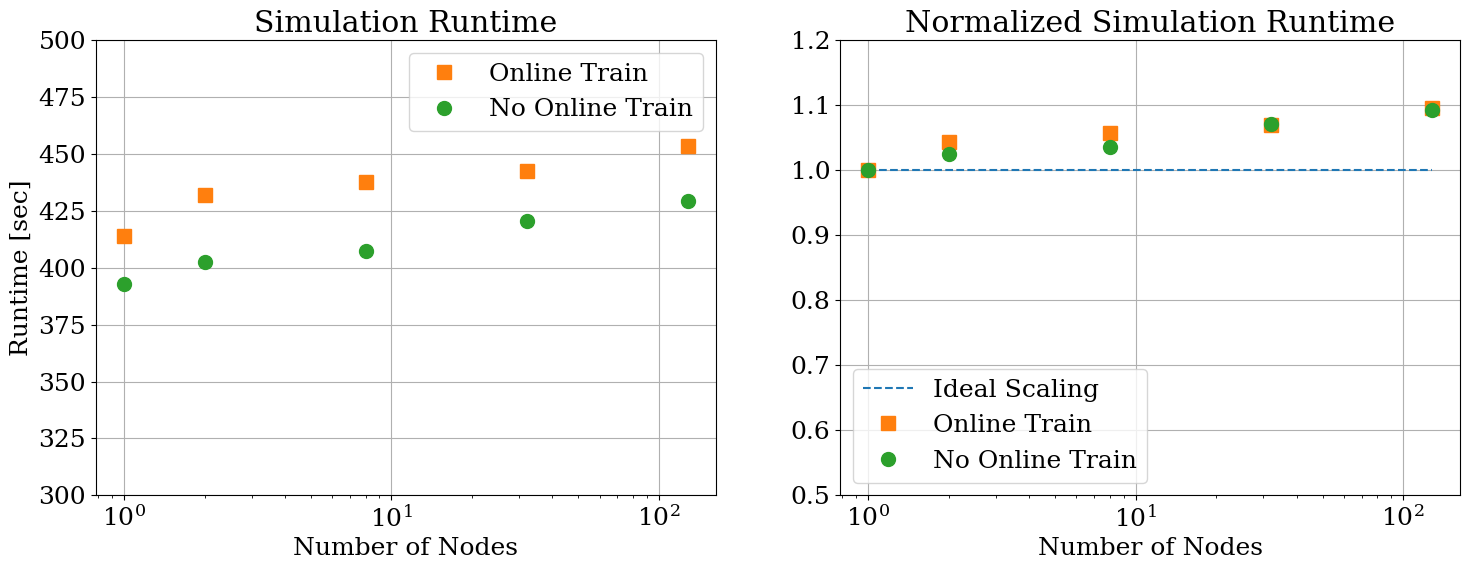

In [9]:
# Simulation runtime with and without online training
nodes = len(node_list)
ideal_abs = workflow.sim_runtime[0]*np.ones((nodes,))
ideal_eta = np.ones((nodes,))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
axs[0].plot(node_list, 100*ideal_abs,label = "", ls="--")
axs[0].plot(node_list, workflow.sim_runtime, label = "Online Train",marker="s",ls="",markersize=10)
axs[0].plot(node_list, libceed.sim_runtime, label = "No Online Train",marker="o",ls="",markersize=10)

axs[1].plot(node_list, ideal_eta,label = "Ideal Scaling", ls="--")
axs[1].plot(node_list, workflow.sim_runtime_eta,label = "Online Train",marker="s",ls="",markersize=10)
axs[1].plot(node_list, libceed.sim_runtime_eta,label = "No Online Train",marker="o",ls="",markersize=10)

axs[0].set_xscale("log")
axs[0].set_xlabel("Number of Nodes")
axs[0].set_ylabel("Runtime [sec]")
axs[0].set_title("Simulation Runtime")
axs[0].legend()
axs[0].grid()
axs[0].set_ylim(300, 500)
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of Nodes")
axs[1].set_title("Normalized Simulation Runtime")
axs[1].grid()
axs[1].legend()
axs[1].set_ylim(0.5, 1.2)
fig.tight_layout(pad=3.0)

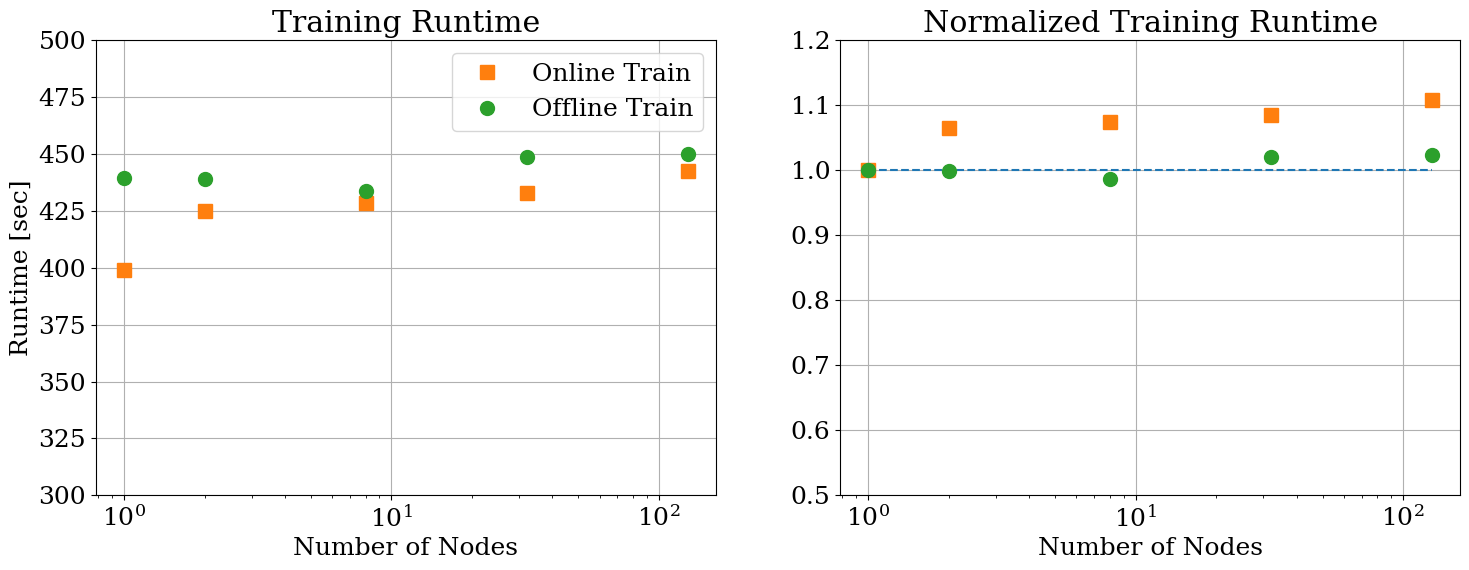

In [10]:
# ML training runtime with and without online training
nodes = len(node_list)
ideal_abs = workflow.ml_runtime[0]*np.ones((nodes,))
ideal_eta = np.ones((nodes,))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
axs[0].plot(node_list, 100*ideal_abs,label = "", ls="--")
axs[0].plot(node_list, workflow.ml_runtime,label = "Online Train",marker="s",ls="",markersize=10)
axs[0].plot(node_list, ml.ml_runtime,label = "Offline Train",marker="o",ls="",markersize=10)

axs[1].plot(node_list, ideal_eta,label = "Ideal Scaling", ls="--")
axs[1].plot(node_list, workflow.ml_runtime_eta,label = "Online Train",marker="s",ls="",markersize=10)
axs[1].plot(node_list, ml.ml_runtime_eta,label = "Offline Train",marker="o",ls="",markersize=10)

axs[0].set_xscale("log")
axs[0].set_xlabel("Number of Nodes")
axs[0].set_ylabel("Runtime [sec]")
axs[0].set_title("Training Runtime")
axs[0].legend()
axs[0].grid()
axs[0].set_ylim(300, 500)
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of Nodes")
axs[1].set_title("Normalized Training Runtime")
axs[1].grid()
axs[1].set_ylim(0.5, 1.2)
fig.tight_layout(pad=3.0)

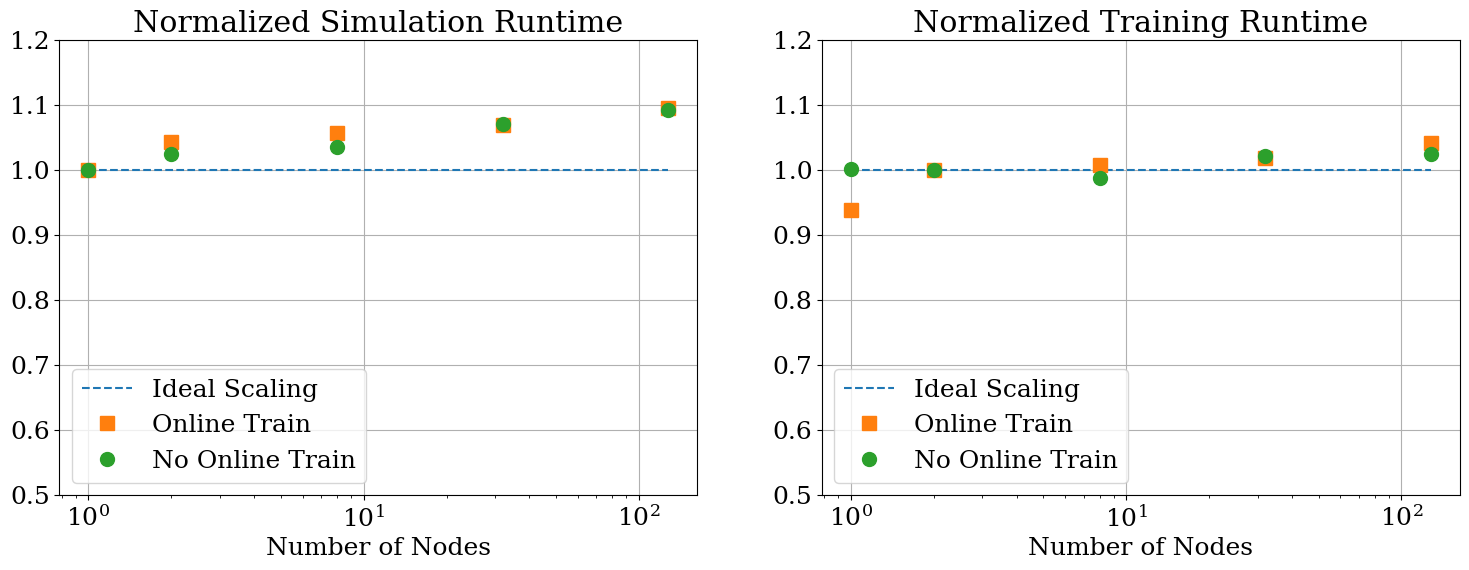

In [12]:
# Weak scaling of simulation and training
nodes = len(node_list)
ideal_abs = workflow.sim_runtime[0]*np.ones((nodes,))
ideal_eta = np.ones((nodes,))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
axs[0].plot(node_list, ideal_eta,label = "Ideal Scaling", ls="--")
axs[0].plot(node_list, workflow.sim_runtime_eta,label = "Online Train",marker="s",ls="",markersize=10)
axs[0].plot(node_list, libceed.sim_runtime_eta,label = "No Online Train",marker="o",ls="",markersize=10)

axs[1].plot(node_list, ideal_eta,label = "Ideal Scaling", ls="--")
#axs[1].plot(node_list, workflow.ml_runtime_eta,label = "Online Train",marker="s",ls="",markersize=10)
#axs[1].plot(node_list, ml.ml_runtime_eta,label = "No Online Train",marker="o",ls="",markersize=10)
axs[1].plot(node_list, workflow.ml_runtime/workflow.ml_runtime[1],label = "Online Train",marker="s",ls="",markersize=10)
axs[1].plot(node_list, ml.ml_runtime/ml.ml_runtime[1],label = "No Online Train",marker="o",ls="",markersize=10)

axs[0].set_xscale("log")
axs[0].set_xlabel("Number of Nodes")
axs[0].set_title("Normalized Simulation Runtime")
axs[0].grid()
axs[0].legend()
axs[0].set_ylim(0.5, 1.2)

axs[1].set_xscale("log")
axs[1].set_xlabel("Number of Nodes")
axs[1].set_title("Normalized Training Runtime")
axs[1].grid()
axs[1].legend()
axs[1].set_ylim(0.5, 1.2)
fig.tight_layout(pad=3.0)

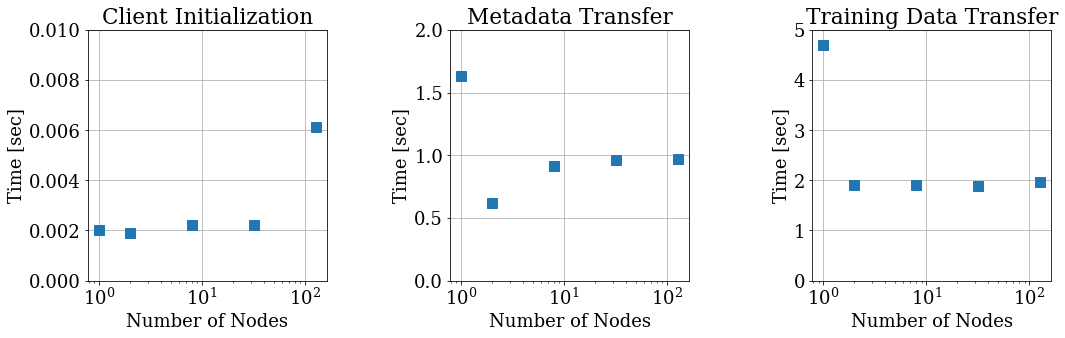

In [76]:
# Overhead of SmartRedis components on simulation
nodes = len(node_list)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
axs[0].plot(node_list, workflow.sim_sr_init,label = "Online Train",marker="s",ls="",markersize=10)

axs[1].plot(node_list, workflow.sim_sr_meta,label = "Online Train",marker="s",ls="",markersize=10)

axs[2].plot(node_list, workflow.sim_sr_train,label = "Online Train",marker="s",ls="",markersize=10)

axs[0].set_xscale("log")
axs[0].set_xlabel("Number of Nodes")
axs[0].set_ylabel("Time [sec]")
axs[0].set_title("Client Initialization")
#axs[0].legend()
axs[0].grid()
axs[0].set_ylim(0, 0.01)
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of Nodes")
axs[1].set_ylabel("Time [sec]")
axs[1].set_title("Metadata Transfer")
axs[1].grid()
axs[1].set_ylim(0, 2)
axs[2].set_xscale("log")
axs[2].set_xlabel("Number of Nodes")
axs[2].set_ylabel("Time [sec]")
axs[2].set_title("Training Data Transfer")
axs[2].grid()
axs[2].set_ylim(0, 5)
fig.tight_layout(pad=3.0)

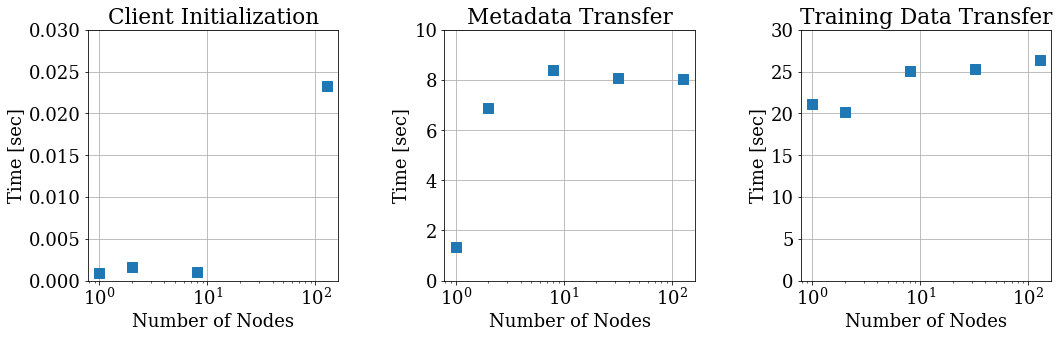

In [11]:
# Overhead of SmartRedis components on ML training
nodes = len(node_list)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
axs[0].plot(node_list, workflow.ml_sr_init,label = "Online Train",marker="s",ls="",markersize=10)

axs[1].plot(node_list, workflow.ml_sr_meta,label = "Online Train",marker="s",ls="",markersize=10)

axs[2].plot(node_list, workflow.ml_sr_train,label = "Online Train",marker="s",ls="",markersize=10)

axs[0].set_xscale("log")
axs[0].set_xlabel("Number of Nodes")
axs[0].set_ylabel("Time [sec]")
axs[0].set_title("Client Initialization")
#axs[0].legend()
axs[0].grid()
axs[0].set_ylim(0, 0.03)
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of Nodes")
axs[1].set_ylabel("Time [sec]")
axs[1].set_title("Metadata Transfer")
axs[1].grid()
axs[1].set_ylim(0, 10)
axs[2].set_xscale("log")
axs[2].set_xlabel("Number of Nodes")
axs[2].set_ylabel("Time [sec]")
axs[2].set_title("Training Data Transfer")
axs[2].grid()
axs[2].set_ylim(0, 30)
fig.tight_layout(pad=3.0)

No handles with labels found to put in legend.


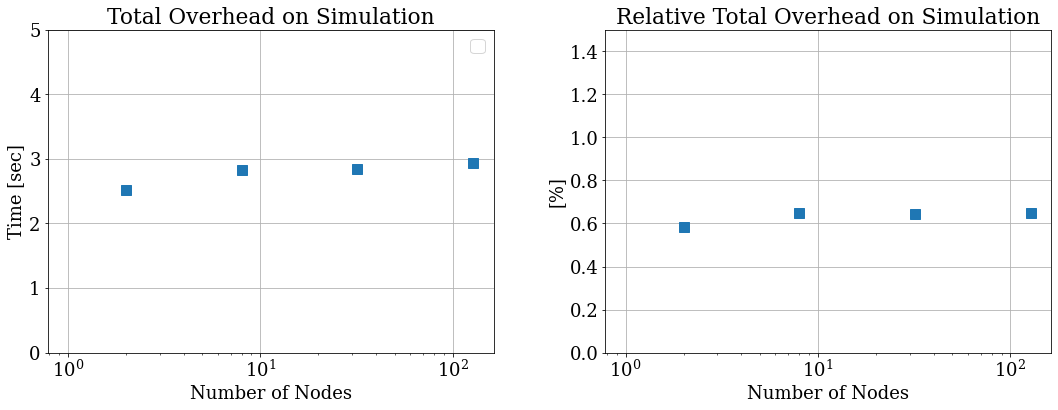

In [78]:
# Total overhead of SmartRedis components on simulation
nodes = len(node_list)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sim_sr_tot = workflow.sim_sr_init + workflow.sim_sr_meta + workflow.sim_sr_train

axs[0].plot(node_list, sim_sr_tot,label = "",marker="s",ls="",markersize=10)

axs[1].plot(node_list, sim_sr_tot/workflow.sim_runtime*100,label = "Online Train",marker="s",ls="",markersize=10)


axs[0].set_xscale("log")
axs[0].set_xlabel("Number of Nodes")
axs[0].set_ylabel("Time [sec]")
axs[0].set_title("Total Overhead on Simulation")
axs[0].legend()
axs[0].grid()
axs[0].set_ylim(0, 5)
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of Nodes")
axs[1].set_ylabel("[%]")
axs[1].set_title("Relative Total Overhead on Simulation")
axs[1].grid()
axs[1].set_ylim(0, 1.5)
fig.tight_layout(pad=3.0)

No handles with labels found to put in legend.


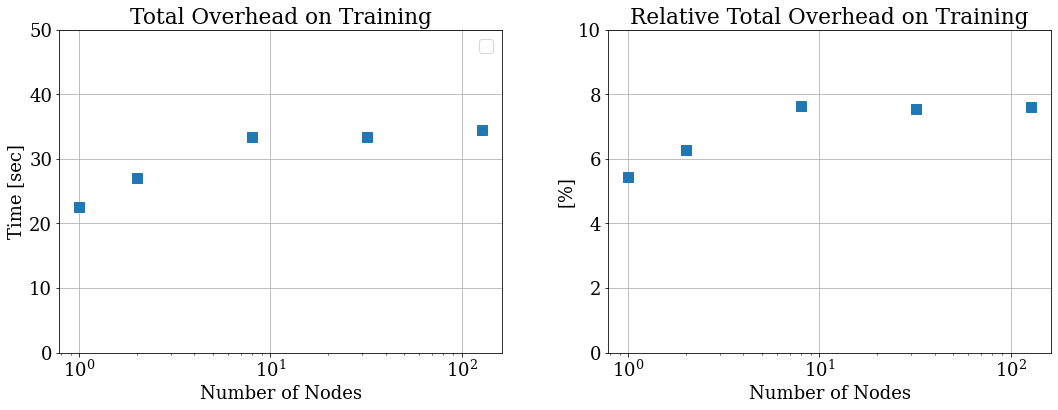

In [79]:
# Total overhead of SmartRedis components on ML training
nodes = len(node_list)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
ml_sr_tot = workflow.ml_sr_init + workflow.ml_sr_meta + workflow.ml_sr_train

axs[0].plot(node_list, ml_sr_tot,label = "",marker="s",ls="",markersize=10)

axs[1].plot(node_list, ml_sr_tot/workflow.sim_runtime*100,label = "Online Train",marker="s",ls="",markersize=10)


axs[0].set_xscale("log")
axs[0].set_xlabel("Number of Nodes")
axs[0].set_ylabel("Time [sec]")
axs[0].set_title("Total Overhead on Training")
axs[0].legend()
axs[0].grid()
axs[0].set_ylim(0, 50)
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of Nodes")
axs[1].set_ylabel("[%]")
axs[1].set_title("Relative Total Overhead on Training")
axs[1].grid()
axs[1].set_ylim(0, 10)
fig.tight_layout(pad=3.0)

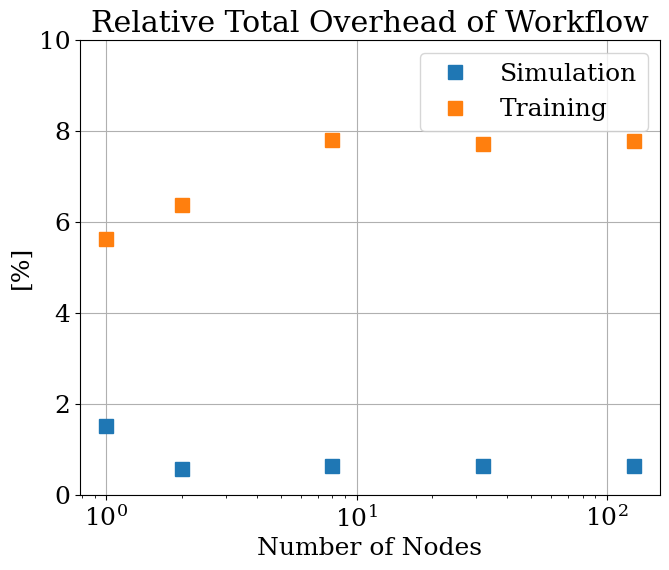

In [13]:
# Total overhead of SmartRedis components on simulation
nodes = len(node_list)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))
sim_sr_tot = workflow.sim_sr_init + workflow.sim_sr_meta + workflow.sim_sr_train
ml_sr_tot = workflow.ml_sr_init + workflow.ml_sr_meta + workflow.ml_sr_train
axs.plot(node_list, sim_sr_tot/workflow.sim_runtime*100,label = "Simulation",marker="s",ls="",markersize=10)
axs.plot(node_list, ml_sr_tot/workflow.ml_runtime*100,label = "Training",marker="s",ls="",markersize=10)

axs.set_xscale("log")
axs.set_xlabel("Number of Nodes")
axs.set_ylabel("[%]")
axs.set_title("Relative Total Overhead of Workflow")
axs.grid()
axs.legend()
axs.set_ylim(0, 10)
fig.tight_layout(pad=3.0)

In [14]:
workflow.sim_runtime

array([413.974, 431.937, 437.827, 442.519, 453.355])

In [15]:
workflow.ml_runtime

array([399.0182, 424.7609, 428.5457, 432.705 , 442.3662])

In [16]:
ml_sr_tot

array([22.49056035, 27.08567614, 33.47117148, 33.41858886, 34.47430069])

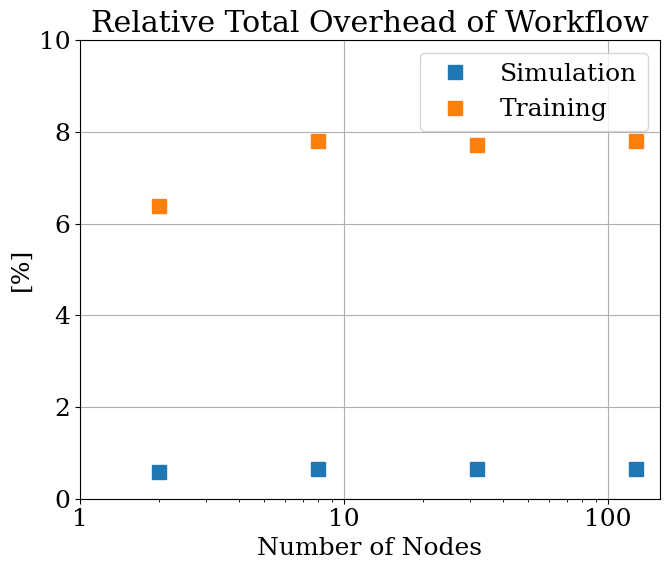

In [23]:
# Total overhead of SmartRedis components on simulation
nodes = len(node_list)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))
sim_sr_tot = workflow.sim_sr_init + workflow.sim_sr_meta + workflow.sim_sr_train
ml_sr_tot = workflow.ml_sr_init + workflow.ml_sr_meta + workflow.ml_sr_train
axs.plot(node_list[1:], sim_sr_tot[1:]/workflow.sim_runtime[1:]*100,label = "Simulation",marker="s",ls="",markersize=10)
axs.plot(node_list[1:], ml_sr_tot[1:]/workflow.ml_runtime[1:]*100,label = "Training",marker="s",ls="",markersize=10)

axs.set_xscale("log")
axs.set_xlabel("Number of Nodes")
axs.set_ylabel("[%]")
axs.set_title("Relative Total Overhead of Workflow")
axs.grid()
axs.legend()
axs.set_ylim(0, 10)
axs.set_xticks([1, 10, 100])
axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.tight_layout(pad=3.0)

# Aurora Scaling

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


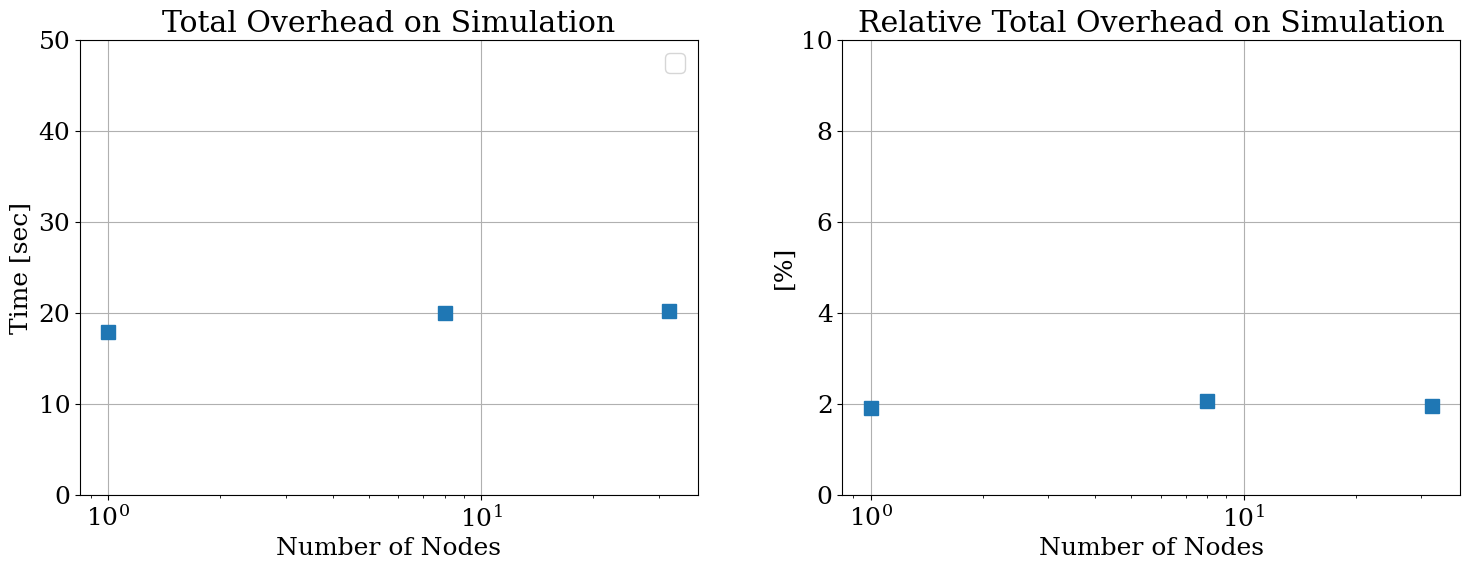

In [11]:
# Total overhead of SmartRedis components on simulation
node_list = [1, 8, 32]
nodes = len(node_list)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sim_sr_tot = workflow_a.sim_sr_init + workflow_a.sim_sr_meta + workflow_a.sim_sr_train

axs[0].plot(node_list, sim_sr_tot,label = "",marker="s",ls="",markersize=10)

axs[1].plot(node_list, sim_sr_tot/workflow_a.sim_runtime*100,label = "Online Train",marker="s",ls="",markersize=10)


axs[0].set_xscale("log")
axs[0].set_xlabel("Number of Nodes")
axs[0].set_ylabel("Time [sec]")
axs[0].set_title("Total Overhead on Simulation")
axs[0].legend()
axs[0].grid()
axs[0].set_ylim(0, 50)
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of Nodes")
axs[1].set_ylabel("[%]")
axs[1].set_title("Relative Total Overhead on Simulation")
axs[1].grid()
axs[1].set_ylim(0, 10)
fig.tight_layout(pad=3.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


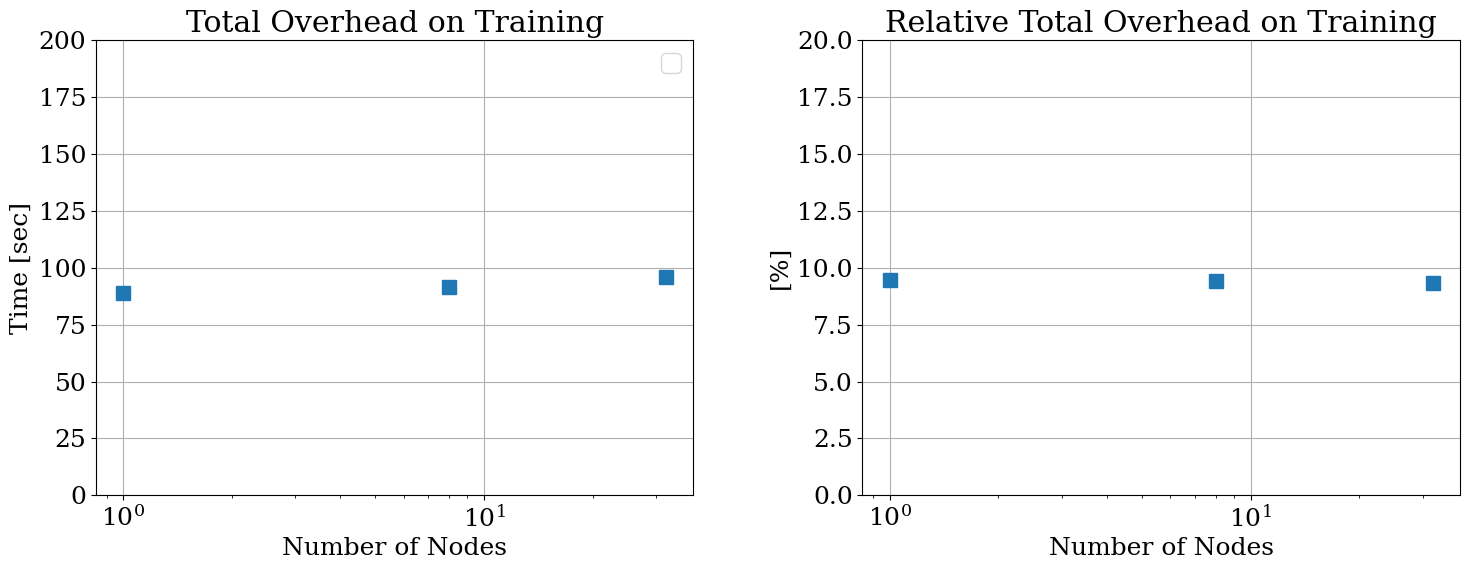

In [14]:
# Total overhead of SmartRedis components on ML training
node_list = [1, 8, 32]
nodes = len(node_list)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
ml_sr_tot = workflow_a.ml_sr_init + workflow_a.ml_sr_meta + workflow_a.ml_sr_train

axs[0].plot(node_list, ml_sr_tot,label = "",marker="s",ls="",markersize=10)

axs[1].plot(node_list, ml_sr_tot/workflow_a.sim_runtime*100,label = "Online Train",marker="s",ls="",markersize=10)


axs[0].set_xscale("log")
axs[0].set_xlabel("Number of Nodes")
axs[0].set_ylabel("Time [sec]")
axs[0].set_title("Total Overhead on Training")
axs[0].legend()
axs[0].grid()
axs[0].set_ylim(0, 200)
axs[1].set_xscale("log")
axs[1].set_xlabel("Number of Nodes")
axs[1].set_ylabel("[%]")
axs[1].set_title("Relative Total Overhead on Training")
axs[1].grid()
axs[1].set_ylim(0, 20)
fig.tight_layout(pad=3.0)